# Trabalho Final - Computação Científica e Análise de Dados

## Tópico: Aplicação do PCA para algoritmos de Reconhecimento Facial

---
Nome: Gabriel Santos Schuina

DRE: 121056295

---

O objetivo desse trabalho é explorar a aplicação do PCA para obtenção de eigenfaces e explorar a utilização delas no reconhecimento facial. O trabalho em suma será dividido em duas grandes partes. Na primeira aplicaremos o PCA em um subconjunto do dataset para explorarmos algumas visualizações em dimensão 2. Na segunda parte do projeto, objetiva-se aplicar o PCA em toda a base para observar os resultados de reconhecimento facial em uma base bem preenchida.

1. Analisando comportamento do PCA em um dataset com duas pessoas
2. PCA aplicado em todo o dataset

In [54]:
# bibliotecas e funções utilizadas no projeto
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from uteis import *

O dataset que foi escolhido para trabalhar essa aplicação é `fetch_olivetti_faces`, o qual possui uma base bem solidificada com **400** imagens de dimensão **64x64** pixels, sendo essas de 40 pessoas diferentes. Ou seja, no dataset há 10 fotos de cada indivíduo. O dataset é obtido através do módulo `scikit-learn` e ele nos fornece um `bunch`, no qual é possível obter 3 grandes conjuntos de dados:

- `data`: uma matriz (**400x4096**), na qual cada linha representa uma imagem na forma de um vetor
- `images`: uma matriz 3D (**400x64x64**), na qual abrange as imagens dos individuos no seu formato original
- `targets`: um vetor com **400** entrada que tem por objetivo marcar o ID da foto do usuário de cada linha da matriz `data`

Os principais utilizados no projeto são os conjuntos `data` e `targets`

In [55]:
# Importando o dataset
faces_bunch = fetch_olivetti_faces()

data = faces_bunch.data
images = faces_bunch.images
targets = faces_bunch.target

Breve visualização de como são as imagens do dataset

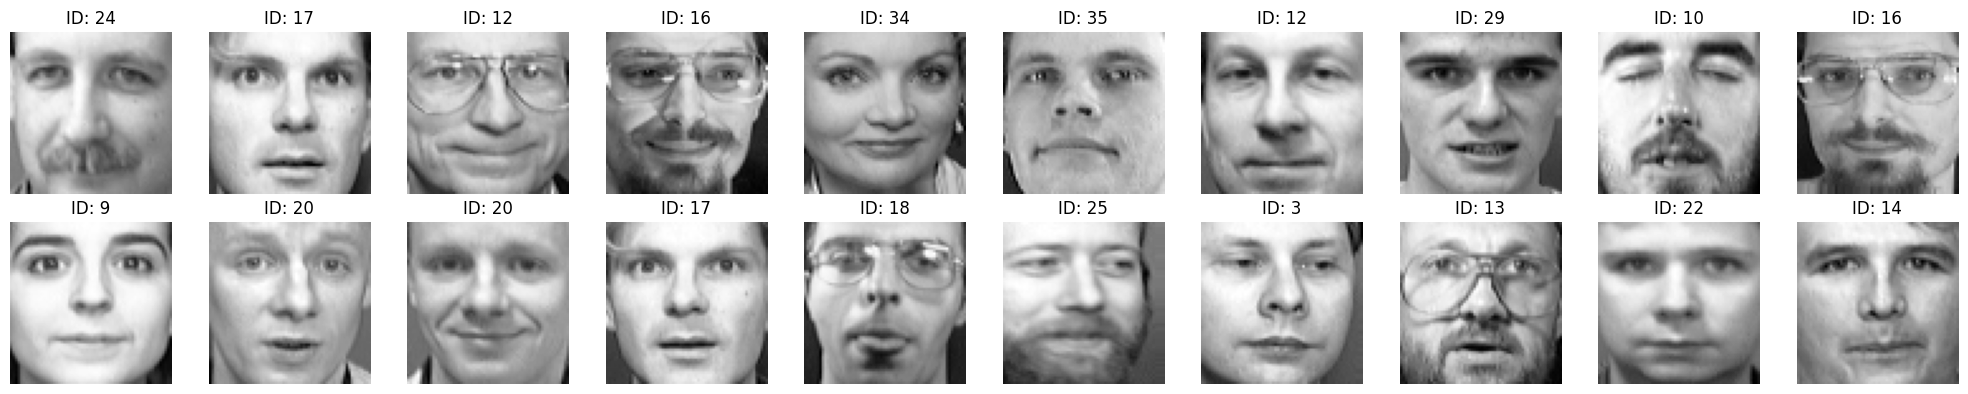

In [56]:
# Seleciona 20 índices aleatórios do dataset
indices_aleatorios = np.random.choice(len(images), size=20, replace=False)

# Plota as 20 imagens selecionadas
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i, idx in enumerate(indices_aleatorios):
    ax = axes[i // 10, i % 10]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'ID: {targets[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 1. Analisando Comportamento do PCA em um Dataset com duas pessoas

O objetivo dessa primeira parte é explorar um aspecto visual do PCA em dimensão 2. Para isso, serão selecionadas 2 pessoas aleatórias do dataset e será montada uma matriz com os dados dessas duas pessoas. Para obtermos uma visualização em dimensão 2, rodaremos o PCA 2 e obteremos as 2 componentes principais. Após isso, projetaremos os dados do dataset das 2 pessoas no espaço gerado por essas duas componentes e, por fim, projetaremos nossos vetores de teste, separados anteriormente e veremos o comportamento do gráfico.

Aqui foram selecionadas 2 pessoas aleatórias do dataset `fetch_olivetti_faces`. Dessas 2 pessoas, foi requisitado as 10 fotos de cada uma delas e selecionada, também aleatóriamente 1 foto de cada pessoa, a qual servirá de teste futuramente. No bloco imediatamente abaixo é observado a obtenção das imagens da primeira e da segunda pessoa e a separação das respectivas imagens de teste.


In [57]:
ids = np.unique(targets)  # IDs únicos das pessoas

np.random.seed(43)  # Para reprodutibilidade

# Seleciona dois IDs aleatórios
id1 = np.random.choice(ids)
id2 = np.random.choice(ids[ids != id1])

# Para cada pessoa, seleciona os índices das imagens
indices_pessoa1 = np.where(targets == id1)[0]
indices_pessoa2 = np.where(targets == id2)[0]

# Seleciona aleatoriamente um índice de teste para cada pessoa
indice_teste_pessoa1 = np.random.choice(indices_pessoa1, size=1, replace=False)[0]
indice_teste_pessoa2 = np.random.choice(indices_pessoa2, size=1, replace=False)[0]

# Índices de treino (remove o de teste)
indices_treino_pessoa1 = indices_pessoa1[indices_pessoa1 != indice_teste_pessoa1]
indices_treino_pessoa2 = indices_pessoa2[indices_pessoa2 != indice_teste_pessoa2]

# Obtém as imagens de treino e teste para cada pessoa
pessoa1_treino = data[indices_treino_pessoa1]
pessoa2_treino = data[indices_treino_pessoa2]
pessoa1_teste = data[indice_teste_pessoa1]
pessoa2_teste = data[indice_teste_pessoa2]

# Concatena os dados de treino das duas pessoas
data_2_pessoas = np.concatenate((pessoa1_treino, pessoa2_treino), axis=0)
# Concatena os targets de treino das duas pessoas
targets_2_pessoas = np.concatenate((
    np.full(len(pessoa1_treino), id1),
    np.full(len(pessoa2_treino), id2)
))

# Imagens de teste e seus targets
data_teste_2_pessoas = np.stack([pessoa1_teste, pessoa2_teste])
targets_teste_2_pessoas = np.array([id1, id2])

Uma boa observação métrica anterior ao cálculo de fato do PCA 2, é observar o gráfico dos autovalores para termos uma noção prévia do quanto estamos capturando do dado. Para isso então, calcularei o PCA no conjunto de dados das 2 pessoas, sem definir o número de componentes anteriormente.

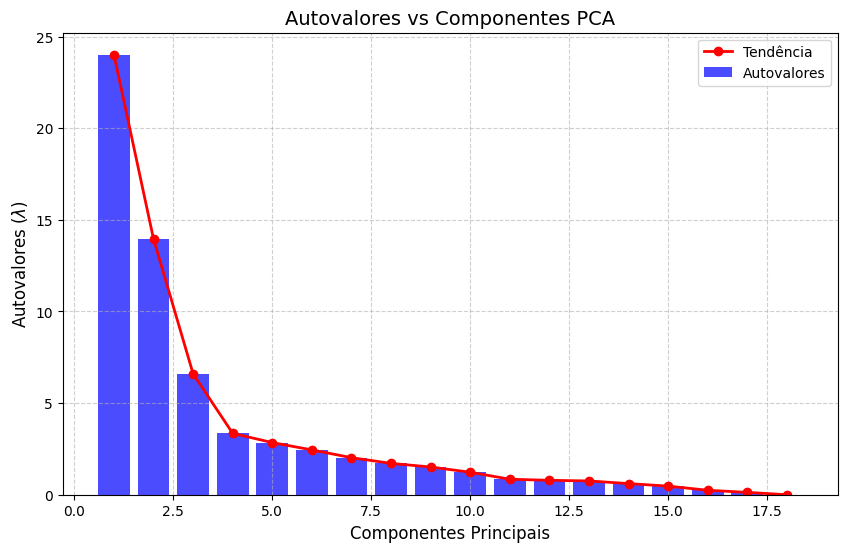

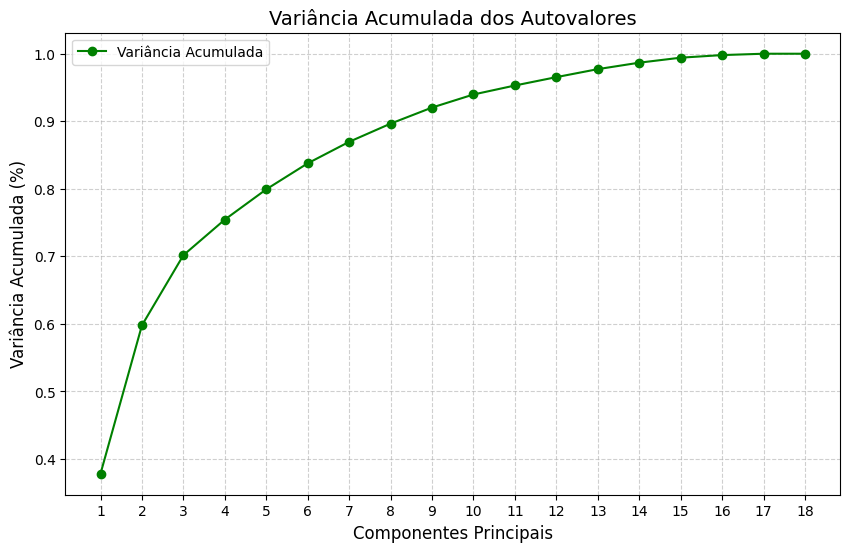

In [58]:
pca = PCA(n_components=None)
pca.fit(data_2_pessoas)
# Plotando o gráfico de autovalores
plotar_grafico_cotovelo(pca.explained_variance_)   
plotar_grafico_variancia_acumulada(pca.explained_variance_ratio_)

Uma métrica mais exata que apenas a análise do gráfico é calcular diretamente a soma dos valores percentuais que cada autovalor representa. Como para nosso primeiro teste faremos apenas até o PCA 2, somarei até a segunda componente apenas.

In [59]:
percentual_capturado = np.sum(pca.explained_variance_ratio_[:2])
print(f"Percentual de variância capturado pelas 2 primeiras componentes principais: {percentual_capturado:.2%}")

Percentual de variância capturado pelas 2 primeiras componentes principais: 59.78%


Após essas análises e tendo as imagens das duas pessoas selecionadas em uma matriz `18x4096`, lembrando que cada imagem se encontra em uma linha, irei agora aplicar o PCA para reduzir nossos dados para dimensão 2 e assim analisar o quanto essa redução de dimensionalidade é capaz de capturar nossos dados originais.

In [60]:
# Como selecionamos apenas duas pessoas, o número de componentes 
# principais que queremos são 2. Para simplificar os nomes das variáveis
# indicarei 2_ para indicar que são dados de duas pessoas.

num_componentes = 2
pca = PCA(n_components=num_componentes)
# Ajusta o PCA aos dados de treino
pca.fit(data_2_pessoas)

eigenfaces_2_ = pca.components_
eigenfaces_importancia_2_ = pca.explained_variance_
eigenfaces_importancia_relativa_2_ = pca.explained_variance_ratio_

projecoes_2_ = pca.transform(data_2_pessoas)
projecoes_teste_2_ = pca.transform(data_teste_2_pessoas)

Visualização das Eigenfaces

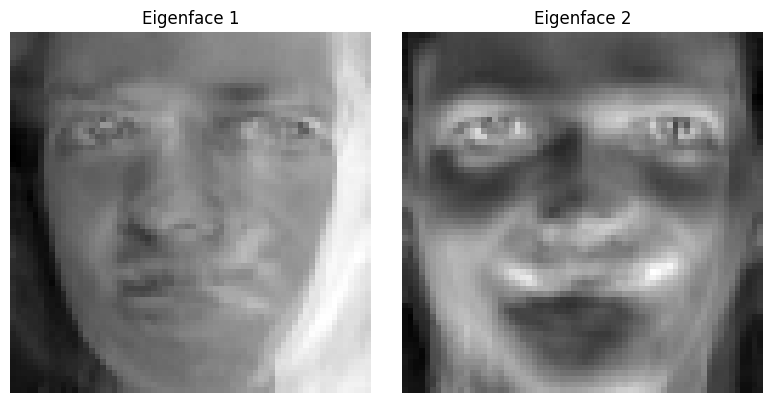

In [61]:
# plotando as eigenfaces lado a lado
fig, axes = plt.subplots(1, num_componentes, figsize=(8, 4))
for i in range(num_componentes):
    ax = axes[i] if num_componentes > 1 else axes
    ax.imshow(eigenfaces_2_[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Após o PCA ser aplicado, agora desejamos observar a disposição das nossas imagens (agora em 2D) plotadas em um gráfico

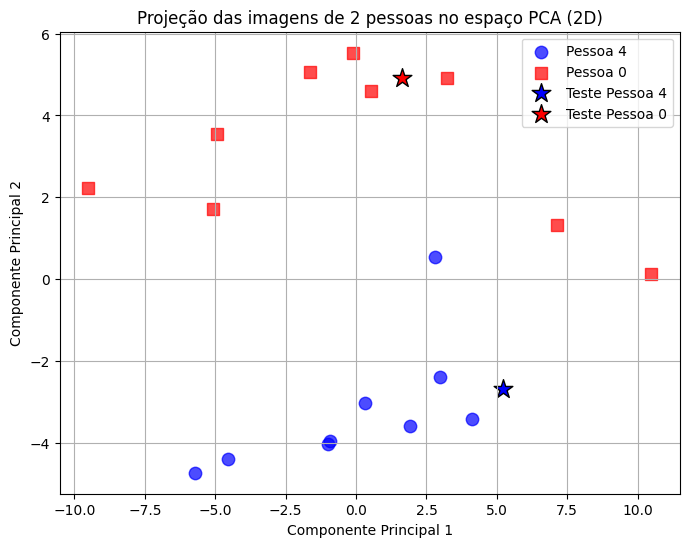

In [62]:
# Plota as projeções das imagens das duas pessoas no espaço 2D das componentes principais
plt.figure(figsize=(8, 6))
for id_pessoa, cor, marcador in zip([id1, id2], ['blue', 'red'], ['o', 's']):
    idx = targets_2_pessoas == id_pessoa
    plt.scatter(projecoes_2_[idx, 0], projecoes_2_[idx, 1], 
                label=f'Pessoa {id_pessoa}', c=cor, marker=marcador, s=80, alpha=0.7)

# Plota as imagens de teste com indicadores diferentes para cada pessoa
for i, (x, y) in enumerate(projecoes_teste_2_):
    if targets_teste_2_pessoas[i] == id1:
        plt.scatter(x, y, label=f'Teste Pessoa {id1}', c='blue', marker='*', s=200, edgecolor='black')
    elif targets_teste_2_pessoas[i] == id2:
        plt.scatter(x, y, label=f'Teste Pessoa {id2}', c='red', marker='*', s=200, edgecolor='black')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Projeção das imagens de 2 pessoas no espaço PCA (2D)')
plt.legend()
plt.grid(True)
plt.show()

Para efeito de visualização abaixo estão as imagens das duas pessoas que foram utilizadas nesse teste. As 9 primeiras imagens de cada linha são as imagens utilizadas no treino do PCA e as ultimas de cada linha são as que foram utilizadas nos testes.

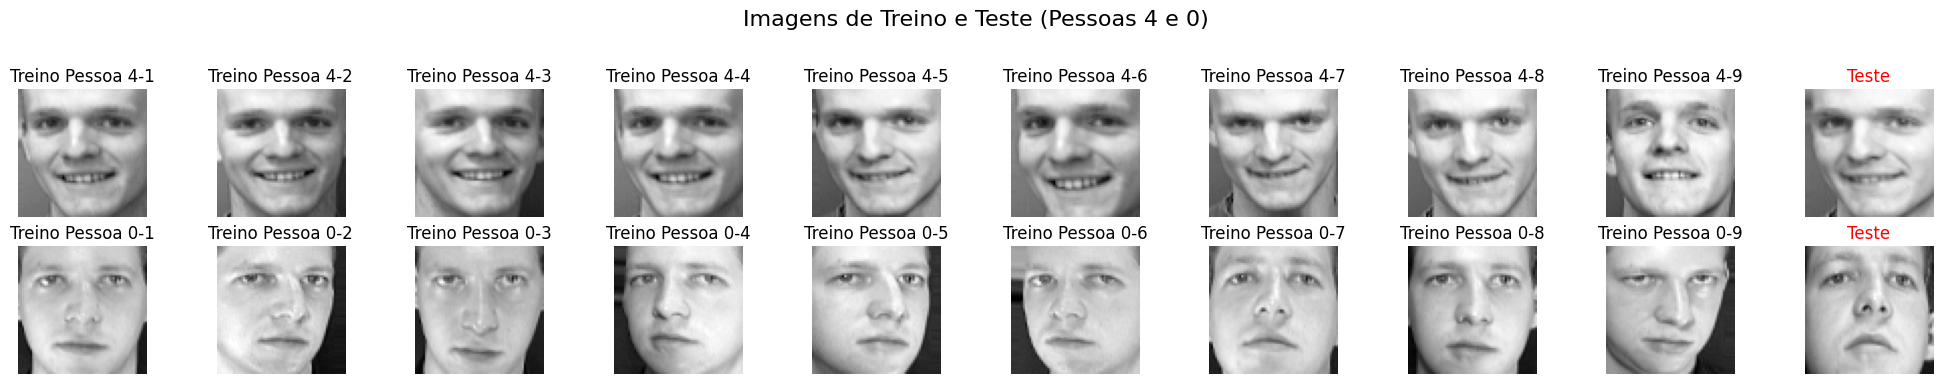

In [63]:
# Cria um grid 2x10 para exibir as imagens
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
fig.suptitle(f'Imagens de Treino e Teste (Pessoas {id1} e {id2})', fontsize=16)

# Exibe as 9 imagens de treino da pessoa 1
for i in range(9):
    ax = axes[0, i]
    ax.imshow(pessoa1_treino[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Treino Pessoa {id1}-{i+1}')
    ax.axis('off')

# Exibe a imagem de teste da pessoa 1 na 10ª coluna
axes[0, 9].imshow(pessoa1_teste.reshape(64, 64), cmap='gray')
axes[0, 9].set_title('Teste')
axes[0, 9].axis('off')
axes[0, 9].title.set_color('red')


# Exibe as 9 imagens de treino da pessoa 2
for i in range(9):
    ax = axes[1, i]
    ax.imshow(pessoa2_treino[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Treino Pessoa {id2}-{i+1}')
    ax.axis('off')

# Exibe a imagem de teste da pessoa 2 na 10ª coluna
axes[1, 9].imshow(pessoa2_teste.reshape(64, 64), cmap='gray')
axes[1, 9].set_title('Teste')
axes[1, 9].axis('off')
axes[1, 9].title.set_color('red')

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

---

# 2. Aplicando PCA em todo o Dataset

Para esse segundo teste, o objetivo é utilizar as imagens de todas as pessoas do Dataset. De início, desejo selecionar 1 imagem de cada pessoa para usar de teste após a aplicação do PCA. Isso é feito no bloco abaixo.

In [64]:
# Desejo selecionar um número de imagens que não serão aplicadas no
# treino do algoritmo para utilizar de teste posteriormente
def separar_treino_teste(targets):
    indices_teste = []
    ids = np.unique(targets)
    # Para cada pessoa, seleciona aleatoriamente 1 imagem para teste
    for id_pessoa in ids:
        # Encontra os índices de todas as imagens dessa pessoa
        indices = np.where(targets == id_pessoa)[0]
        # Escolhe aleatoriamente 1 índice para teste
        indice_teste = np.random.choice(indices, size=1, replace=False)
        indices_teste.append(indice_teste)

    # Converte para array unidimensional
    indices_teste = np.concatenate(indices_teste)

    # Máscara booleana para separar treino e teste
    mascara_teste = np.zeros(len(targets), dtype=bool)
    mascara_teste[indices_teste] = True  # True = teste, False = treino

    return mascara_teste

mascara_teste = separar_treino_teste(targets)

# Divide-se os dados
data_treino, data_teste = data[~mascara_teste], data[mascara_teste]
targets_treino, targets_teste = targets[~mascara_teste], targets[mascara_teste]

Após separadas as imagens para o treino e para o teste, minha ideia é avaliar qual número ideal de componentes são necessárias para capturar 95% dos dados originais

In [65]:
# Esse bloco objetiva a decisão do número de componentes que serão
# escolhidos
pca = PCA(n_components=None)
pca.fit(data_treino)
all_autovalores = pca.explained_variance_
all_autovalores_percentuais = pca.explained_variance_ratio_

Para ter um olhar visual sobre as informações alguns plots de gráficos serão mostrados abaixo. Nesses gráficos temos o valor dos autovalores por número de componentes

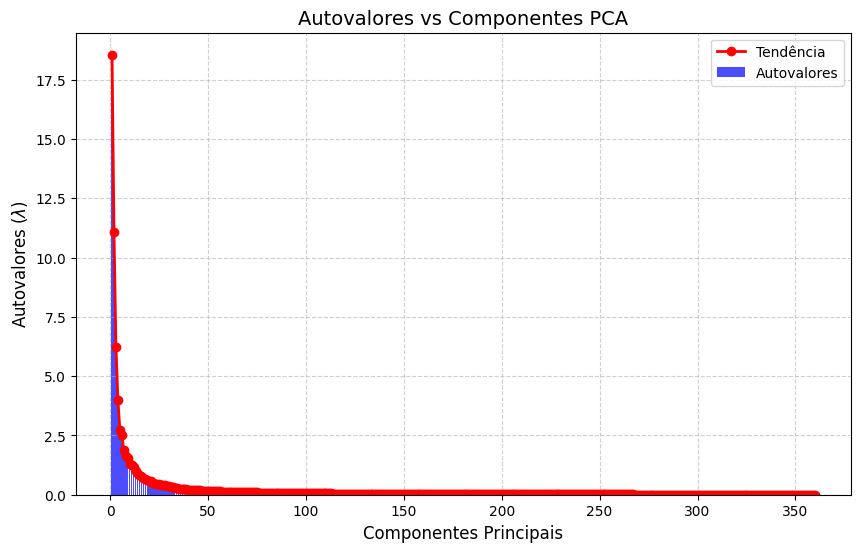

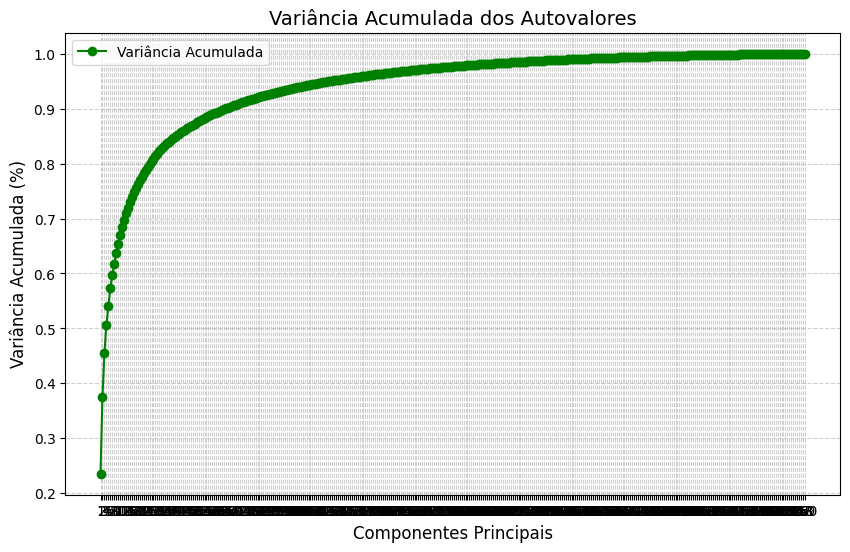

In [66]:
# Avalia-se diferentes gráficos cotovelos para obter o número
# de componentes ideal visualmente
plotar_grafico_cotovelo(all_autovalores)
plotar_grafico_variancia_acumulada(all_autovalores_percentuais)
# plotar_grafico_cotovelo(all_autovalores[:200])
# plotar_grafico_cotovelo(all_autovalores[:100])
# plotar_grafico_cotovelo(all_autovalores[:50])

Não é possível obter a informação precisa do percentual do dado capturado pelos gráficos, haja vista que há muitos autovalores. Por isso a melhor forma de fazer isso é analisar matematicamente somando os autovalores até uma determinada componentes e dividindo pela soma total de todas as componentes. Ou melhor, como temos um vetor que nos diz o percentual que cada autovalor captura o dado, basta somarmos esses valores até atingirmos a métrica de 0.95 que é desejada.

In [67]:
# Matemáticamente agora desejamos obter o número de componentes
# para um determinado percentual de precisão desejado.
percentual_desejado = 0.95
k = procurar_num_componentes(percentual_desejado, all_autovalores_percentuais)
print(f"{k} componentes necessárias para {percentual_desejado * 100} % de precisão")

118 componentes necessárias para 95.0 % de precisão


Assim foi possível obter que **118** componentes são suficientes para haver uma captura de **95%** do Dataset

Agora necessitamos obter as eigenfaces, seus pesos e os autovalores associados. A partir do número de componentes ideal obtido anteriormente, agora aplicaremos o PCA 118 em cima do nosso dataset, para obtermos as projeções e aplicar os testes.

In [68]:
# Aplicação do PCA para o número de componentes obtido no bloco acima
pca = PCA(n_components=k)
pca.fit(data_treino)

eigenfaces = pca.components_    # autovetores da matriz AA^t
eigenfaces_importancia = pca.explained_variance_    # autovalores da matriz AA^t
eigenfaces_importancia_percentual = pca.explained_variance_ratio_   # autovalores percentuais da matriz AA^t
                                                                    # autovalor/sum(autovalores)

projecoes = pca.fit_transform(data_treino) # matriz com os pesos de cada eigenface
                                           # para cada foto do dataset original

Agora que temos nossas eigenfaces, podemos pegar nossas imagens de teste e projetar no espaço gerado por elas e assim avaliar se o algoritmo foi capaz de encontrar a pessoa dentro do dataset. Para avaliar qual pessoa aquela imagem é do dataset é utilizado apenas a distância euclidiana entre a projeção da imagem de teste e as projeções das imagens de treino. Sendo assim, a imagem de teste que tiver a menor distância da imagem de treino será aquela considerada a pessoa identificada.

In [69]:
projecoes_teste = pca.transform(data_teste)  # projeção dos dados de teste
proximos = []  # lista para armazenar os índices das imagens mais próximas

m = 10 # número de imagens a serem analisadas
for i in range(m):
    treino_i = projecoes_teste[i]
    # Calcula a distância euclidiana entre a imagem de teste e as projeções de treino
    distancias = np.linalg.norm(projecoes - treino_i, axis=1)
    # Encontra o índice da imagem mais próxima
    indice_mais_proximo = np.argmin(distancias)
    # print(f"Imagem de teste {i+1} mais próxima da imagem de treino {indice_mais_proximo+1} (ID: {targets_treino[indice_mais_proximo]})")
    proximos.append(indice_mais_proximo)

Uma medida interessante é contar quantos matchs o nosso algoritmo acertou

In [70]:
# Contagem de acertos
acertos = 0
for i, indice in enumerate(proximos):
    if targets_treino[indice] == targets_teste[i]:
        acertos += 1

print(f"Número de acertos: {acertos} de {m} imagens testadas.")

Número de acertos: 8 de 10 imagens testadas.


Para uma melhor avaliação é interessante observar o match entre as imagens utilizadas no teste e as imagens do treino que foram identificadas como mais próximas. Nessa visualização poderemos observar os possíveis erros, e os acertos do nosso algoritmo.

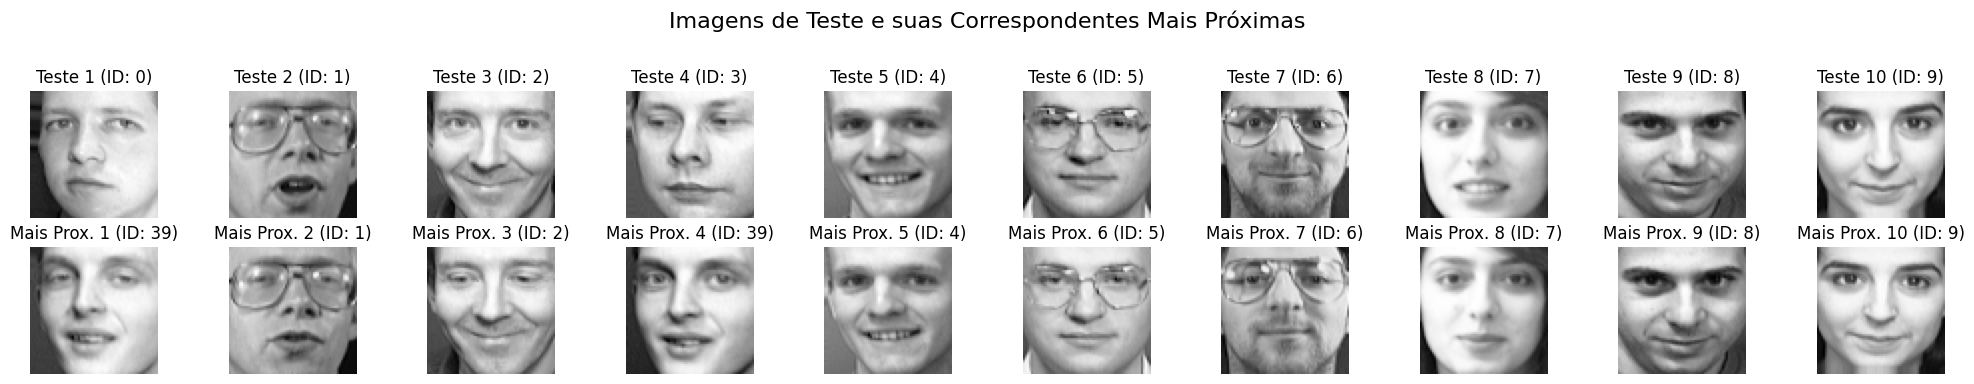

In [71]:
# Plota as imagens de teste e suas correspondentes mais próximas
fig, axes = plt.subplots(2, m, figsize=(20, 4))
fig.suptitle(f'Imagens de Teste e suas Correspondentes Mais Próximas', fontsize=16)
# Exibe as imagens de teste
for i in range(m):
    ax = axes[0, i]
    ax.imshow(data_teste[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Teste {i+1} (ID: {targets_teste[i]})')
    ax.axis('off')
# Exibe as imagens mais próximas
for i, indice in enumerate(proximos):
    ax = axes[1, i]
    ax.imshow(data_treino[indice].reshape(64, 64), cmap='gray')
    ax.set_title(f'Mais Prox. {i+1} (ID: {targets_treino[indice]})')
    ax.axis('off')
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

## Sugestão de Melhoria: Definir o limiar de similaridade

Para evitar ao máximo o caso de matchs incorretos observados nos testes anteriores, é interessante definir um limiar de similaridade a partir das imagens de treino, para assim verificar se uma pessoa teste é de fato aquela identificada pelo algoritmo. A ideia desse limiar é ser um parâmetro de referência para indicar se uma pessoa está no dataset e ainda por cima para garantir que uma pessoa que está no dataset, dê match com ela mesma e não com outra pessoa.

In [72]:
# # Definindo o limiar de similaridade
# ids = np.unique(targets)
# distancias_intra = obter_distancias_intra(ids, projecoes, targets_treino)
# distancias_inter = obter_distancias_inter(ids, projecoes, targets_treino)

# media_intra = np.mean(distancias_intra)
# dp_intra = np.std(distancias_intra)

# media_inter = np.mean(distancias_inter)
# dp_inter = np.std(distancias_inter)

# limiar1 = media_intra + 2 * dp_intra    # limiar de similaridade baseado em desvio padrão

In [73]:
# def obter_limiar_eer(distancias_intra, distancias_inter):
#     # Cria-se vetores de labels (0 = intra-classe, 1 = inter-classe)
#     labels = np.concatenate([
#         np.zeros(len(distancias_intra)),  # 0 para intra-classe
#         np.ones(len(distancias_inter))    # 1 para inter-classe
#     ])

#     # Concatenar todas as distâncias
#     distancias = np.concatenate([distancias_intra, distancias_inter])

#     # Calcular FPR e TPR (usando a função ROC do scikit-learn)
#     fpr, tpr, limiares = roc_curve(labels, distancias)

#     # Encontrar o limiar onde FPR ≈ 1 - TPR (FNR)
#     limiar_eer = limiares[np.argmin(np.abs(fpr - (1 - tpr)))]
    
#     return limiar_eer

# limiar_eer = obter_limiar_eer(distancias_intra, distancias_inter)
# print(f"Limiar EER: {limiar_eer}")